In [9]:
file_name = "combined_sampling_update" #"Mol2Mol"
save_directory = "analysis"
report = {}

# Preliminary - File Concatenation

In [2]:
import pandas as pd
import os

names = ["Mol2Mol_sampling_update", "Reinvent_sampling_update"]

# Prepare containers to stack entries
all_original_properties = []
all_updated_properties = []
all_update_mappings = []

for n in names:
    print(f"Processing {n}...")

    # Define paths
    original_property_path = f"property/{n}.csv"
    updated_property_path = f"property/{n}_update.csv"
    update_mapping_path = f"update/{n}.csv"

    # Read and add 'Method' column to identify source
    df_original = pd.read_csv(original_property_path)
    df_original['Method'] = n
    all_original_properties.append(df_original)

    df_updated = pd.read_csv(updated_property_path)
    df_updated['Method'] = n + "_update"
    all_updated_properties.append(df_updated)

    df_mapping = pd.read_csv(update_mapping_path)
    df_mapping['Method'] = n
    all_update_mappings.append(df_mapping)

# Stack (concatenate) by type
stacked_original_df = pd.concat(all_original_properties, ignore_index=True)
stacked_updated_df = pd.concat(all_updated_properties, ignore_index=True)
stacked_mapping_df = pd.concat(all_update_mappings, ignore_index=True)

# Save all combined data
# os.makedirs("combined", exist_ok=True)
stacked_original_df.to_csv(f"property/{file_name}.csv", index=False)
stacked_updated_df.to_csv(f"property/{file_name}_update.csv", index=False)
stacked_mapping_df.to_csv(f"update/{file_name}.csv", index=False)

print("✅ Stacked files saved with 'Method' column in the save directory.")

Processing Mol2Mol_sampling_update...
Processing Reinvent_sampling_update...
✅ Stacked files saved with 'Method' column in the save directory.


# Update vs. Original

In [2]:
import pandas as pd
from rdkit import Chem


# method = "Mol2Mol" #"Reinvent"
original_update_mapping_path = f"update/{file_name}.csv"
df = pd.read_csv(original_update_mapping_path)
invalid_count = 0
for index, row in df.iterrows():
    smiles = row['Updated_SMILES']
    if pd.isna(smiles):
        continue
    smiles = smiles.strip()
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        #print(f"Invalid SMILES at index {index}: {smiles}")
        invalid_count += 1


print("-" * 50)
print(f"data number: {len(df)}")
print(f"invalid SMILES: {invalid_count}")
print("-" * 50)

report['method'] = file_name
report['data_number'] = len(df)
report['invalid_smiles'] = invalid_count

--------------------------------------------------
data number: 95
invalid SMILES: 1
--------------------------------------------------


[11:54:41] SMILES Parse Error: syntax error while parsing: 'COCc1ccc(C(=O)c2c3c(cc4ccccc24)OCO3)cc1'
[11:54:41] SMILES Parse Error: check for mistakes around position 1:
[11:54:41] 'COCc1ccc(C(=O)c2c3c(cc4ccccc24)OCO3)cc1'
[11:54:41] ^
[11:54:41] SMILES Parse Error: Failed parsing SMILES ''COCc1ccc(C(=O)c2c3c(cc4ccccc24)OCO3)cc1'' for input: ''COCc1ccc(C(=O)c2c3c(cc4ccccc24)OCO3)cc1''


## Summary

In [3]:
import pandas as pd
# method = "Mol2Mol"
original_property_path = f"property/{file_name}.csv"
original_update_mapping_path = f"update/{file_name}.csv"
updated_property_path = f"property/{file_name}_update.csv"

# Load data
original_property_df = pd.read_csv(original_property_path)
updated_property_df = pd.read_csv(updated_property_path)
update_mapping_df = pd.read_csv(original_update_mapping_path)

# Collect results here
results = []
for index, row in update_mapping_df.iterrows():
    original_smiles = row['SMILES'].strip()
    updated_smiles = row['Updated_SMILES'].strip()
    property_name = row['Property'].strip().replace("'", "")

    # Normalize property name if needed
    if not any(suffix in property_name for suffix in ["Predictions", "Interpretation", "Probability"]):
        property_name += " Predictions"

    # Validate SMILES presence
    if original_smiles not in original_property_df['SMILES'].values:
        print(f"[Missing] Original SMILES not found: {original_smiles}")
        continue
    if updated_smiles not in updated_property_df['SMILES'].values:
        print(f"[Missing] Updated SMILES not found: {updated_smiles}")
        continue

    try:
        original_value = original_property_df.loc[
            original_property_df['SMILES'] == original_smiles, property_name
        ].values[0]

        updated_value = updated_property_df.loc[
            updated_property_df['SMILES'] == updated_smiles, property_name
        ].values[0]

        # Determine direction
        if isinstance(original_value, (int, float)) and isinstance(updated_value, (int, float)):
            if original_value < updated_value:
                direction = "up"
            elif original_value > updated_value:
                direction = "down"
            else:
                direction = "-"

        elif isinstance(original_value, str) and isinstance(updated_value, str):
            if original_value == updated_value:
                direction = "-"
            elif original_value == 'Toxic' and updated_value == 'Safe':
                direction = "safe"
            elif original_value == 'Safe' and updated_value == 'Toxic':
                direction = "toxic"
            elif original_value == 'Inhibitor' and updated_value != 'Inhibitor':
                direction = "Non-Inhibitor"
        # else:
        #     direction = "non-numerical"

        # Append to result list
        results.append({
            "Property": property_name,
            "Original_SMILES": original_smiles,
            "Updated_SMILES": updated_smiles,
            "Original_Value": original_value,
            "Updated_Value": updated_value,
            "Direction": direction
        })

    except KeyError as e:
        print(f"[KeyError] Property not found: {property_name}")
        continue
    except IndexError:
        print(f"[IndexError] Value missing for SMILES or property: {original_smiles}, {updated_smiles}")
        continue

# Convert results to DataFrame
result_df = pd.DataFrame(results)

# (Optional) Save to CSV
result_df.to_csv(f"{save_directory}/compare_{file_name}.csv", index=False)

# Preview the result
result_df

[KeyError] Property not found: Toxicity/AMES Mutagenesis Predictions
[KeyError] Property not found: Invalid SMILES Predictions
[KeyError] Property not found: Invalid SMILES Predictions
[KeyError] Property not found: Invalid SMILES Predictions
[KeyError] Property not found: Absorption/Human Oral Bioavailability 20% and 50% Predictions
[KeyError] Property not found: Carcinogenesis Predictions
[KeyError] Property not found: Toxicity/AMES Mutagenesis Predictions
[KeyError] Property not found: Toxicity Predictions
[Missing] Updated SMILES not found: 'COCc1ccc(C(=O)c2c3c(cc4ccccc24)OCO3)cc1'


,Property,Original_SMILES,Updated_SMILES,Original_Value,Updated_Value,Direction
0,[Absorption/Caco-2 (logPaap)] Predictions,O=C(NS(=O)(=O)c1ccc(N2CCN(Cc3ccccc3Cl)CC2=O)cc...,O=C(NS(=O)(=O)c1ccc(N2CCN(Cc3ccccc3Cl)CC2=O)cc...,-5.79,-5.83,down
1,[Absorption/Caco-2 (logPaap)] Predictions,CC(C)CNc1ccc(S(=O)(=O)NC(=O)c2ccc(N3CCN(C)C(=O...,CC(C)CNc1ccc(S(=O)(=O)NC(=O)c2ccc(N3CCN(C)C(=O...,-5.74,-5.74,-
2,[Absorption/Caco-2 (logPaap)] Predictions,O=C(Nc1ccc(N2CCN(CC3CCC3)CC2=O)cc1)c1ccc(Cl)nc1Cl,O=C(Nc1ccc(N2CCN(CC3CCC3)CC2C)cc1)c1ccc(Cl)nc1Cl,-4.54,-4.59,down
3,[Absorption/Caco-2 (logPaap)] Predictions,CN(C)CCNc1ccc(S(=O)(=O)NC(=O)c2ccc(N3CCN(C/C=C...,CN(C)CCNc1ccc(C(=O)c2ccc(N3CCN(C/C=C/c4ccccc4)...,-5.56,-5.34,up
4,[Absorption/Caco-2 (logPaap)] Predictions,COc1ccccc1S(=O)(=O)NC(=O)c1ccc(N2CCN(C)C(=O)C2...,COc1ccccc1S(=O)(=O)NC(=O)c1ccc(N2CCN(C)C2)c(Oc...,-5.21,-5.09,up
...,...,...,...,...,...,...
81,[Absorption/Caco-2 (logPaap)] Predictions,CCc1ccc(CN2CCc3c(cc(C(=O)N4CCOC5(CCNC5)C4)n3C)...,CCc1ccc(CN2CCc3c(cc(C(=O)N4CCOC5(CCNC5)C4)n3C)...,-5.14,-5.14,-
82,[Absorption/Caco-2 (logPaap)] Predictions,CC1CNC(CC(=O)Nc2ccc(-c3ccccc3)cc2)c2c(nc3ccccn...,CC1CNC(CC(=O)Nc2ccc(-C)cc2)c2c(nc3ccccn23)C1=O,-5.1,-4.93,up
83,[Toxicity/AMES Mutagenesis] Predictions,NC(=O)c1[nH]c(=Nc2cccc3ccccc23)sc1C(=O)c1ccccc1F,NC(=O)c1[nH]c(=Nc2cccc3ccccc23)sc1C(=O)c1ccccc1F,Toxic,Toxic,-
84,[Absorption/Caco-2 (logPaap)] Predictions,N#Cc1ccc(-c2ccc(CN(C(=O)Cc3cc(O)ccc3)c3ccc4c(c...,N#Cc1ccc(-c2ccc(CN(C(=O)Cc3ccccc3)c3ccc4c(c3)C...,-5.25,-5.28,down


## Absorption property comparison

In [4]:
# === [Caco-2 Permeability Statistics] ===
specific_property = "[Absorption/Caco-2 (logPaap)] Predictions"
threshold_value = -5.0

# Filter by property
property_df = result_df[result_df['Property'] == specific_property]
print(f"\nTotal entries for '{specific_property}': {len(property_df)}")

# Count direction values
up_count = property_df[property_df['Direction'] == 'up'].shape[0]
down_count = property_df[property_df['Direction'] == 'down'].shape[0]
no_change_count = property_df[property_df['Direction'] == '-'].shape[0]
print(f"Up: {up_count}, Down: {down_count}, No Change: {no_change_count}")

# Filter by threshold on Original_Value
numeric_df = property_df.copy()
numeric_df['Original_Value'] = pd.to_numeric(numeric_df['Original_Value'], errors='coerce')
filtered_df = numeric_df[numeric_df['Original_Value'] < threshold_value]

print(f"\nFiltered results for '{specific_property}' with Original_Value < {threshold_value}: {len(filtered_df)} entries")

# Count direction values in filtered set
filtered_up_count = filtered_df[filtered_df['Direction'] == 'up'].shape[0]
filtered_down_count = filtered_df[filtered_df['Direction'] == 'down'].shape[0]
filtered_no_change_count = filtered_df[filtered_df['Direction'] == '-'].shape[0]
print(f"Filtered Up: {filtered_up_count}, Filtered Down: {filtered_down_count}, Filtered No Change: {filtered_no_change_count}")
result = {
    "Property": specific_property,
    "Total": len(property_df),
    "Up": up_count,
    "Down": down_count,
    "No Change": no_change_count,
    "Filter Threshold": threshold_value,
    "Filtered Count": len(filtered_df),
    "Filtered Up": filtered_up_count,
    "Filtered Down": filtered_down_count,
    "Filtered No Change": filtered_no_change_count
}
summary_df = pd.DataFrame([result])
result.pop('Property')
report[specific_property] = result

#summary_df.to_csv(f"analysis/summary_{method}_{specific_property.replace('/', '_').replace(' ', '_')}.csv", index=False)


Total entries for '[Absorption/Caco-2 (logPaap)] Predictions': 65
Up: 34, Down: 11, No Change: 20

Filtered results for '[Absorption/Caco-2 (logPaap)] Predictions' with Original_Value < -5.0: 44 entries
Filtered Up: 27, Filtered Down: 4, Filtered No Change: 13


## Toxicity property comparison

In [5]:
# === [Toxicity Statistics] ===
specific_property = "Toxicity"
threshold_value = "Toxic"

# Filter by property (partial match)
property_df = result_df[result_df['Property'].str.contains(specific_property, na=False)]
print(f"\nTotal entries for '{specific_property}': {len(property_df)}")

# Count direction values
safe_count = property_df[property_df['Direction'] == 'safe'].shape[0]
toxic_count = property_df[property_df['Direction'] == 'toxic'].shape[0]
no_change_count = property_df[property_df['Direction'] == '-'].shape[0]
print(f"Safe: {safe_count}, Toxic: {toxic_count}, No Change: {no_change_count}")

# Filter by exact match on Original_Value
filtered_df = property_df[property_df['Original_Value'] == threshold_value]
print(f"\nFiltered results for '{specific_property}' with Original_Value = '{threshold_value}': {len(filtered_df)} entries")

# Count direction values in filtered set
filtered_safe_count = filtered_df[filtered_df['Direction'] == 'safe'].shape[0]
filtered_toxic_count = filtered_df[filtered_df['Direction'] == 'toxic'].shape[0]
filtered_no_change_count = filtered_df[filtered_df['Direction'] == '-'].shape[0]
print(f"Filtered Safe: {filtered_safe_count}, Filtered Toxic: {filtered_toxic_count}, Filtered No Change: {filtered_no_change_count}")

result = {
    "Property": specific_property,
    "Total": len(property_df),
    "Up": safe_count,
    "Down": toxic_count,
    "No Change": no_change_count,
    "Filter Threshold": threshold_value,
    "Filtered Count": len(filtered_df),
    "Filtered Up": filtered_safe_count,
    "Filtered Down": filtered_toxic_count,
    "Filtered No Change": filtered_no_change_count
}
summary_df = pd.DataFrame([result])
result.pop('Property')
report[specific_property] = result

#summary_df.to_csv(f"analysis/summary_{method}_{specific_property.replace('/', '_').replace(' ', '_')}.csv", index=False)



Total entries for 'Toxicity': 15
Safe: 3, Toxic: 0, No Change: 12

Filtered results for 'Toxicity' with Original_Value = 'Toxic': 15 entries
Filtered Safe: 3, Filtered Toxic: 0, Filtered No Change: 12


# Rule-based Evaluation


In [1]:
import os, sys
cwd = os.getcwd()
print("Current working directory:", cwd)
home_dir = os.path.dirname(os.path.dirname(cwd))
print("Home directory:", home_dir)
sys.path.append(home_dir)

import pandas as pd
from rdkit.Chem import QED
from rdkit import Chem
from agentD.analysis_utils import rule_based_evaluation

Current working directory: /home/hoon/dd-agent/llm_dd/examples/BCL-2
Home directory: /home/hoon/dd-agent/llm_dd


In [2]:
def process_dataset_with_agent(file_path: str) -> pd.DataFrame:
    """
    Reads the dataset and applies the LLM-driven analysis to each entry.

    Args:
        file_path (str): Path to the dataset file.
        protein (str): Target protein for drug analysis.
        objective (str): Target objective for drug analysis.
        agent: The LLM agent object.

    Returns:
        pd.DataFrame: DataFrame with the original data and LLM assessments.
    """
    # Read dataset
    df = pd.read_csv(file_path)

    # Prepare list to store output
    results = []

    # Iterate through each row
    for _, row in df.iterrows():
        # rule-based evaluation
        entry = row.to_dict()

        qed_score = QED.qed(Chem.MolFromSmiles(entry['SMILES']))
        report = rule_based_evaluation(entry)
        report['QED'] = qed_score
        # binding affinity determination
        affinity = entry["Affinity [pKd]"]
        report['Affinity'] = affinity
        
        results.append({"Method": entry["Method"], **report})

    # Create and return the new DataFrame
    return pd.DataFrame(results)


In [ ]:
# from agentD.tools.prediction import predict_affinity
# input_data='{"sequence": "MAHAGRTGYDNREIVMKYIHYKLSQRGYEWDAGDVGAAPPGAAPAPGIFSSQPGHTPHPAASRDPVARTSPLQTPAAPGAAAGPALSPVPPVVHLTLRQAGDDFSRRYRRDFAEMSSQLHLTPFTARGRFATVVEELFRDGVNWGRIVAFFEFGGVMCVESVNREMSPLVDNIALWMTEYLNRHLHTWIQDNGGWDAFVELYGPSMRPLFDFSWLSLKTLLSLALVGACITLGAYLGHK", "smiles": "CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NCC5CCOCC5)c([N+](=O)[O-])c4)c(Oc4cnc5[nH]ccc5c4)c3)CC2)=C(c2ccc(Cl)cc2)C1"}'

# predict_affinity(input_data)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


6.340292930603027

In [ ]:
import os

for suffix in ["", "_update"]:
    # Define property file path
    property_file = f"property/{file_name}{suffix}.csv"
    
    # Process the dataset
    processed_data = process_dataset_with_agent(property_file)
    #processed_data['Method'] = method + suffix
    # Save the processed data
    save_path = os.path.join(save_directory, os.path.basename(property_file))
    print(save_path)
    processed_data.to_csv(save_path, index=False)
    
    # Compute and store statistics
    stats_key = f"rule_eval{suffix}" if suffix else "rule_eval"
    report[stats_key] = processed_data.describe().to_dict()

analysis/venetoclax.csv
analysis/venetoclax.csv


In [ ]:
import json

with open(f"{save_directory}/report_{file_name}.json", "w") as f:
    json.dump(report, f, indent=4)

# Molecule Refinement Tracking

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
compare_origin_first = pd.read_csv("analysis/compare_combined_sampling.csv")
compare_first_second = pd.read_csv("analysis/compare_combined_sampling_update.csv")
update_origin_first = pd.read_csv("update/combined_sampling.csv")
update_first_second = pd.read_csv("update/combined_sampling_update.csv")
original_property = pd.read_csv("property/combined_sampling.csv")
first_updated_property = pd.read_csv("property/combined_sampling_update.csv")     
second_updated_property = pd.read_csv("property/combined_sampling_update_update.csv")

In [3]:
# Step 1: Rename columns for clarity before merging
compare_origin_first_renamed = compare_origin_first.rename(columns={
    "Original_SMILES": "original_smiles",
    "Original_Value": "original_value",
    "Updated_SMILES": "updated_smiles_1",
    "Updated_Value": "updated_value_1",
    "Property": "property_1",
    "Direction": "direction_1",
})

compare_first_second_renamed = compare_first_second.rename(columns={
    "Original_SMILES": "updated_smiles_1",  # To join on this
    "Original_Value": "updated_value_1",  # To join on this
    "Updated_SMILES": "updated_smiles_2",
    "Updated_Value": "updated_value_2",
    "Property": "property_2",
    "Direction": "direction_2"
})

# Step 2: Merge based on 'updated_smiles_1'
merged = pd.merge(
    compare_origin_first_renamed,
    compare_first_second_renamed,
    on=["updated_smiles_1"],
)

## Success Case - Up and Up Permeability

In [4]:
# find entries that show ups for direction_1 and direction_2
up_entries = merged[
    (merged['direction_1'] == 'up') & (merged['direction_2'] == 'up')
]
print(f"Number of up entries: {len(up_entries)}")
# change the type to float for updated_value_2 and original_value
up_entries['original_value'] = pd.to_numeric(up_entries['original_value'], errors='coerce')
up_entries['updated_value_2'] = pd.to_numeric(up_entries['updated_value_2'], errors='coerce')
up_entries['value_increase'] = up_entries['updated_value_2'] - up_entries['original_value']
up_entries['value_increase'] = up_entries['value_increase'].astype(float)   

# sort based on the value increase
up_entries = up_entries.sort_values(by='value_increase', ascending=False)
up_entries

Number of up entries: 8


/tmp/ipykernel_289408/1204618153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_entries['original_value'] = pd.to_numeric(up_entries['original_value'], errors='coerce')
/tmp/ipykernel_289408/1204618153.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_entries['updated_value_2'] = pd.to_numeric(up_entries['updated_value_2'], errors='coerce')
/tmp/ipykernel_289408/1204618153.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,property_1,original_smiles,updated_smiles_1,original_value,updated_value_1_x,direction_1,property_2,updated_smiles_2,updated_value_1_y,updated_value_2,direction_2,value_increase
81,[General Properties/Log S] Predictions,Cc1c(CCC(C)C)c(=O)oc2cc(OS(=O)(=O)c3ccc(Cl)cc3...,Cc1c(CCC(C)(CO)C)c(=O)oc2cc(OS(=O)(=O)c3ccc(Cl...,-6.19,-6.03,up,[Absorption/Caco-2 (logPaap)] Predictions,Cc1c(CCC(C)(CO)C)c(=O)oc2cc(OCC)c(Cl)cc12,-5.32,-4.71,up,1.48
27,[Absorption/Caco-2 (logPaap)] Predictions,O=C(NS(=O)(=O)c1ccc(N2CCNCC2)c(O)c1)c1ccc(N2CC...,O=C(NS(=O)(=O)c1ccc(N2CCNCC2)c(C)c1)c1ccc(N2CC...,-6.03,-5.41,up,[Absorption/Caco-2 (logPaap)] Predictions,O=C(Nc1ccc(N2CCNCC2)c(C)c1)c1ccc(N2CCOCC2)c(Cl)c1,-5.41,-5.00,up,1.03
16,[Absorption/Caco-2 (logPaap)] Predictions,CC(C)(C)OC(=O)Nc1ccc(S(=O)(=O)NC(=O)c2ccc(N3CC...,CC(C)(C)OC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(N3CCN(CCO...,-5.52,-5.4,up,[Absorption/Caco-2 (logPaap)] Predictions,CC(C)(C)OC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(N3CCN(CC)...,-5.4,-5.02,up,0.50
72,[Absorption/Caco-2 (logPaap)] Predictions,CC1CC(n2cnc3[nH]c(=O)n(C)c(=O)c32)C(O)C1O,CC1CC(n2cnc3[nH]c(=O)n(C)c(=O)c32)C(O)C1OC,-5.26,-5.09,up,[Absorption/Caco-2 (logPaap)] Predictions,CC1CC(n2cnc3[nH]c(=O)n(C)c(=O)c32)C(OC)C1OC,-5.09,-4.85,up,0.41
44,[Absorption/Caco-2 (logPaap)] Predictions,Cc1ccc(-c2cc(C(=O)NC3CCCCCC3)nn2-c2ccc(-n3cncn...,Cc1ccc(-c2cc(C(=O)OC3CCCCCC3)nn2-c2ccc(-n3cncn...,-4.63,-4.45,up,[Absorption/Caco-2 (logPaap)] Predictions,Cc1ccc(-c2cc(C(=O)OC)nn2-c2ccc(-n3cncn3)nn2)cc1,-4.45,-4.38,up,0.25
63,[Absorption/Caco-2 (logPaap)] Predictions,COc1ccc(-n2nnnc2SCCCn2cnc3ccccc32)c(C)c1,Cc1ccc(-n2nnnc2SCCCn2cnc3ccccc32)c(C)c1,-4.71,-4.69,up,[Absorption/Caco-2 (logPaap)] Predictions,Cc1ccc(-n2nnnc2CCCn2cnc3ccccc32)c(C)c1,-4.69,-4.65,up,0.06
56,[Absorption/Caco-2 (logPaap)] Predictions,COC1NC2=C(C(c3ccccc3Cl)C3C(=O)CCCC3=N2)N1C,COC1NC2=C(C(c3ccccc3)C3C(=O)CCCC3=N2)N1C,-4.68,-4.65,up,[Absorption/Caco-2 (logPaap)] Predictions,CC1NC2=C(C(c3ccccc3)C3C(=O)CCCC3=N2)N1C,-4.65,-4.63,up,0.05
14,[Absorption/Caco-2 (logPaap)] Predictions,O=C(NS(=O)(=O)c1ccc(N2CCOCC2=O)cc1)c1ccc(N2CCN...,O=C(NS(=O)(=O)c1ccc(N2CCOCC2)cc1)c1ccc(N2CCN(C...,-4.98,-4.95,up,[Absorption/Caco-2 (logPaap)] Predictions,O=C(Nc1ccc(N2CCOCC2)cc1)c1ccc(N2CCN(C(=O)OC3CC...,-4.95,-4.94,up,0.04


O=C(NS(=O)(=O)c1ccc(N2CCNCC2)c(O)c1)c1ccc(N2CCOCC2)c(Cl)c1
O=C(NS(=O)(=O)c1ccc(N2CCNCC2)c(C)c1)c1ccc(N2CCOCC2)c(Cl)c1
O=C(Nc1ccc(N2CCNCC2)c(C)c1)c1ccc(N2CCOCC2)c(Cl)c1
Update property: [Absorption/Caco-2 (logPaap)] Predictions --> [Absorption/Caco-2 (logPaap)] Predictions
Update Origin First Rationale: Replaced the hydroxyl group with a methyl group to reduce polarity and potentially improve permeability.
Update First Second Rationale: The modification involves replacing the sulfonamide group with a less polar amine group, which can potentially reduce the polar surface area and improve the molecule's permeability, addressing its poor '[Absorption/Caco-2 (logPaap)] Predictions'.
LogPaap: -6.03 -> -5.41 -> -5.0
LogP: 1.31 -> 2.08 -> 2.69
LogS: -3.12 -> -3.22 -> -3.35


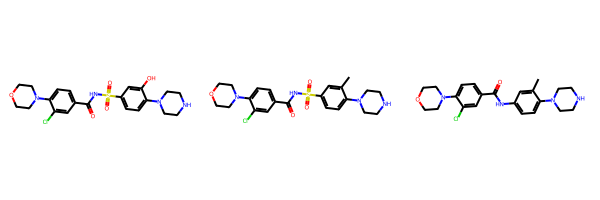

In [5]:
entry_no = 1
original_smiles = up_entries['original_smiles'].iloc[entry_no]
first_updated_smiles = up_entries['updated_smiles_1'].iloc[entry_no]
second_updated_smiles = up_entries['updated_smiles_2'].iloc[entry_no]
first_property = up_entries['property_1'].iloc[entry_no]
second_property = up_entries['property_2'].iloc[entry_no]

matching_origin = update_origin_first[update_origin_first['SMILES'] == original_smiles]['Rationale'].values[0]
matching_update = update_first_second[update_first_second['SMILES'] == first_updated_smiles]['Rationale'].values[0]

matching_original_logPaap = original_property[original_property['SMILES'] == original_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update1_logPaap = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update2_logPaap = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]

matching_origin_logP = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update1_logP = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update2_logP = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]

matching_origin_logS = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update1_logS = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update2_logS = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log S] Predictions'].values[0]

print(f"{original_smiles}")
print(f"{first_updated_smiles}")
print(f"{second_updated_smiles}")
print(f"Update property: {first_property} --> {second_property}")
print(f"Update Origin First Rationale: {matching_origin}")
print(f"Update First Second Rationale: {matching_update}")
print(f"LogPaap: {matching_original_logPaap} -> {matching_update1_logPaap} -> {matching_update2_logPaap}")
print(f"LogP: {matching_origin_logP} -> {matching_update1_logP} -> {matching_update2_logP}")
print(f"LogS: {matching_origin_logS} -> {matching_update1_logS} -> {matching_update2_logS}")



smiles_list = [
    original_smiles,
    first_updated_smiles,
    second_updated_smiles
]
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200))


CC(C)(C)OC(=O)Nc1ccc(S(=O)(=O)NC(=O)c2ccc(N3CCN(CCO)CC3)c(F)c2)cc1[N+](=O)[O-]
CC(C)(C)OC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(N3CCN(CCO)CC3)c(F)c2)cc1
CC(C)(C)OC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(N3CCN(CC)CC3)c(F)c2)cc1
Update property: [Absorption/Caco-2 (logPaap)] Predictions --> [Absorption/Caco-2 (logPaap)] Predictions
Update Origin First Rationale: Replaced the nitro group with a hydrogen atom to reduce polarity and molecular size, potentially improving permeability.
Update First Second Rationale: The modification involved replacing the ethoxy group (CCO) with an ethyl group (CC) in the piperazine ring, which could potentially reduce steric hindrance and slightly increase lipophilicity, thereby improving Caco-2 permeability.
LogPaap: -5.52 -> -5.4 -> -5.02
LogP: 2.36 -> 2.7 -> 3.6
LogS: -4.17 -> -3.76 -> -4.26


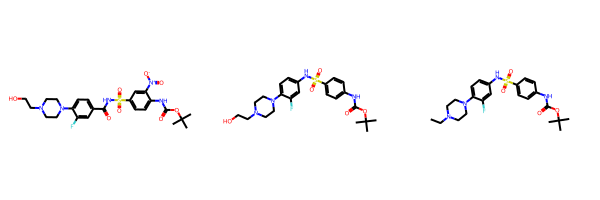

In [7]:
entry_no = 2
original_smiles = up_entries['original_smiles'].iloc[entry_no]
first_updated_smiles = up_entries['updated_smiles_1'].iloc[entry_no]
second_updated_smiles = up_entries['updated_smiles_2'].iloc[entry_no]
first_property = up_entries['property_1'].iloc[entry_no]
second_property = up_entries['property_2'].iloc[entry_no]

matching_origin = update_origin_first[update_origin_first['SMILES'] == original_smiles]['Rationale'].values[0]
matching_update = update_first_second[update_first_second['SMILES'] == first_updated_smiles]['Rationale'].values[0]

matching_original_logPaap = original_property[original_property['SMILES'] == original_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update1_logPaap = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update2_logPaap = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]

matching_origin_logP = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update1_logP = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update2_logP = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]

matching_origin_logS = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update1_logS = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update2_logS = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log S] Predictions'].values[0]

print(f"{original_smiles}")
print(f"{first_updated_smiles}")
print(f"{second_updated_smiles}")
print(f"Update property: {first_property} --> {second_property}")
print(f"Update Origin First Rationale: {matching_origin}")
print(f"Update First Second Rationale: {matching_update}")
print(f"LogPaap: {matching_original_logPaap} -> {matching_update1_logPaap} -> {matching_update2_logPaap}")
print(f"LogP: {matching_origin_logP} -> {matching_update1_logP} -> {matching_update2_logP}")
print(f"LogS: {matching_origin_logS} -> {matching_update1_logS} -> {matching_update2_logS}")



smiles_list = [
    original_smiles,
    first_updated_smiles,
    second_updated_smiles
]
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200))


In [ ]:
# import py3Dmol
# from rdkit.Chem import AllChem
# mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
# for mol in mols:
#     mol = Chem.AddHs(mol)
#     AllChem.EmbedMolecule(mol)

#     mb = Chem.MolToMolBlock(mol)
#     viewer = py3Dmol.view(width=300, height=300)
#     viewer.addModel(mb, "mol")
#     viewer.setStyle({"stick": {}})
#     viewer.zoomTo()
#     viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Failure case - Down and Down Permeability

In [8]:
down_entries = merged[
    (merged['direction_1'] == 'down') & (merged['direction_2'] == 'down')
]
print(f"Number of down entries: {len(down_entries)}")
# change the type to float for updated_value_2 and original_value
down_entries['original_value'] = pd.to_numeric(down_entries['original_value'], errors='coerce')
down_entries['updated_value_2'] = pd.to_numeric(down_entries['updated_value_2'], errors='coerce')
down_entries['value_decrease'] = down_entries['updated_value_2'] - down_entries['original_value']
down_entries['value_decrease'] = down_entries['value_decrease'].astype(float)   

# sort based on the value decrease
down_entries = down_entries.sort_values(by='value_decrease', ascending=True)
down_entries

Number of down entries: 6


/tmp/ipykernel_289408/548499061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_entries['original_value'] = pd.to_numeric(down_entries['original_value'], errors='coerce')
/tmp/ipykernel_289408/548499061.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_entries['updated_value_2'] = pd.to_numeric(down_entries['updated_value_2'], errors='coerce')
/tmp/ipykernel_289408/548499061.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,property_1,original_smiles,updated_smiles_1,original_value,updated_value_1_x,direction_1,property_2,updated_smiles_2,updated_value_1_y,updated_value_2,direction_2,value_decrease
80,[General Properties/Log(P)] Predictions,N#Cc1ccc(-c2ccc(CN(C(=O)Cc3ccccc3)c3ccc4c(c3)C...,N#Cc1ccc(-c2ccc(CN(C(=O)Cc3cc(O)ccc3)c3ccc4c(c...,6.63,6.16,down,[Absorption/Caco-2 (logPaap)] Predictions,N#Cc1ccc(-c2ccc(CN(C(=O)Cc3ccccc3)c3ccc4c(c3)C...,-5.25,-5.28,down,-11.91
64,[General Properties/Log(P)] Predictions,Cc1cccc(C)c1-c1ccc2[nH]c(=NC3CCC(C(C)(C)O)CC3)...,Cc1cccc(C)c1-c1ccc2[nH]c(=NC3CCC(C(C)(C)O)CC3)...,6.25,5.38,down,[Absorption/Caco-2 (logPaap)] Predictions,Cc1cccc(C)c1-c1ccc2[nH]c(=NC3CCC(C)CC3)sc2c1O,-4.98,-5.09,down,-11.34
58,[General Properties/Log(P)] Predictions,CCC1C(CC(C)C)C2=C(CCCC2)N(c2ccc(F)cc2)C1OC,CCC1C(CC(C)C)C2=C(CCCC2)N(c2ccc(F)cc2)C1OCO,7.34,6.51,down,[General Properties/Log(P)] Predictions,CCC1C(CC(C)C)C2=C(CCCC2)N(c2ccc(F)cc2)C1(O)OCO,6.51,5.14,down,-2.20
69,[General Properties/Log(P)] Predictions,Cc1c(C)n(Cc2ccc(-c3ccccc3C(=O)O)cc2)c2ccc(C(=O...,Cc1c(C)n(Cc2ccc(-c3ccccc3C(=O)O)cc2)c2ccc(C(=O...,6.62,5.27,down,[General Properties/Log(P)] Predictions,Cc1c(C)n(Cc2ccc(-c3cc(O)ccc3C(=O)O)cc2)c2ccc(C...,5.27,5.12,down,-1.50
53,[Absorption/Caco-2 (logPaap)] Predictions,COc1cccc(C=Cc2cc3ccc(C(=O)O)cc3[nH]2)c1,COc1cccc(C=Cc2cc3ccc(C(=O)OC)cc3[nH]2)c1,-4.68,-4.87,down,[Absorption/Caco-2 (logPaap)] Predictions,CCc1cccc(C=Cc2cc3ccc(C(=O)OC)cc3[nH]2)c1,-4.87,-5.17,down,-0.49
0,[Absorption/Caco-2 (logPaap)] Predictions,O=C(NS(=O)(=O)c1ccc(N2CCN(Cc3ccccc3Cl)CC2=O)cc...,O=C(NS(=O)(=O)c1ccc(N2CCN(Cc3ccccc3Cl)CC2=O)cc...,-5.76,-5.79,down,[Absorption/Caco-2 (logPaap)] Predictions,O=C(NS(=O)(=O)c1ccc(N2CCN(Cc3ccccc3Cl)CC2=O)cc...,-5.79,-5.83,down,-0.07


COc1cccc(C=Cc2cc3ccc(C(=O)O)cc3[nH]2)c1
COc1cccc(C=Cc2cc3ccc(C(=O)OC)cc3[nH]2)c1
CCc1cccc(C=Cc2cc3ccc(C(=O)OC)cc3[nH]2)c1
Update property: [Absorption/Caco-2 (logPaap)] Predictions --> [Absorption/Caco-2 (logPaap)] Predictions
Update Origin First Rationale: The modification involves converting the carboxylic acid group (-COOH) to a methyl ester (-COOCH3). This change is aimed at increasing the lipophilicity of the molecule, which can enhance its permeability and potentially improve the '[Absorption/Caco-2 (logPaap)] Predictions' value.
Update First Second Rationale: By replacing the methoxy group with an ethoxy group, the lipophilicity is increased, potentially enhancing the molecule's permeability and absorption profile.
LogPaap: -4.68 -> -4.87 -> -5.17
LogP: 4.35 -> 4.81 -> 5.69
LogS: -5.1 -> -6.24 -> -6.2


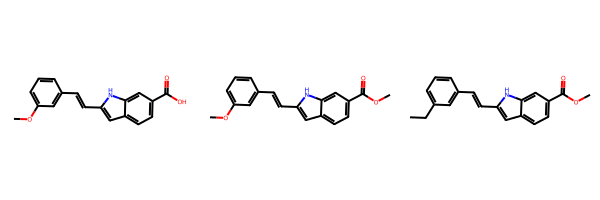

In [9]:
entry_no = 4
original_smiles = down_entries['original_smiles'].iloc[entry_no]
first_updated_smiles = down_entries['updated_smiles_1'].iloc[entry_no]
second_updated_smiles = down_entries['updated_smiles_2'].iloc[entry_no]
first_property = down_entries['property_1'].iloc[entry_no]
second_property = down_entries['property_2'].iloc[entry_no]

matching_origin = update_origin_first[update_origin_first['SMILES'] == original_smiles]['Rationale'].values[0]
matching_update = update_first_second[update_first_second['SMILES'] == first_updated_smiles]['Rationale'].values[0]

matching_original_logPaap = original_property[original_property['SMILES'] == original_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update1_logPaap = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update2_logPaap = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]

matching_origin_logP = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update1_logP = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update2_logP = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]

matching_origin_logS = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update1_logS = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update2_logS = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log S] Predictions'].values[0]

print(f"{original_smiles}")
print(f"{first_updated_smiles}")
print(f"{second_updated_smiles}")
print(f"Update property: {first_property} --> {second_property}")
print(f"Update Origin First Rationale: {matching_origin}")
print(f"Update First Second Rationale: {matching_update}")
print(f"LogPaap: {matching_original_logPaap} -> {matching_update1_logPaap} -> {matching_update2_logPaap}")
print(f"LogP: {matching_origin_logP} -> {matching_update1_logP} -> {matching_update2_logP}")
print(f"LogS: {matching_origin_logS} -> {matching_update1_logS} -> {matching_update2_logS}")



smiles_list = [
    original_smiles,
    first_updated_smiles,
    second_updated_smiles
]
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200))

CCC1C(CC(C)C)C2=C(CCCC2)N(c2ccc(F)cc2)C1OC
CCC1C(CC(C)C)C2=C(CCCC2)N(c2ccc(F)cc2)C1OCO
CCC1C(CC(C)C)C2=C(CCCC2)N(c2ccc(F)cc2)C1(O)OCO
Update property: [General Properties/Log(P)] Predictions --> [General Properties/Log(P)] Predictions
Update Origin First Rationale: The modification involves adding an additional hydroxyl group to the ether linkage, which can increase the polarity of the molecule and potentially reduce the Log(P) value, improving solubility and bioavailability.
Update First Second Rationale: The original molecule had a high Log(P) value of 6.51, indicating poor solubility and potential bioavailability issues. By introducing a hydroxyl group, the polarity of the molecule is increased, which can help reduce the Log(P) value, improving solubility and potentially enhancing pharmacokinetic properties.
LogPaap: -4.82 -> -4.76 -> -4.71
LogP: 7.34 -> 6.51 -> 5.14
LogS: -5.74 -> -5.29 -> -4.75


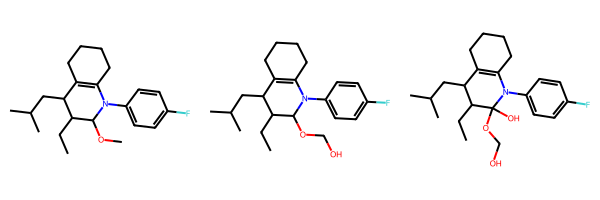

In [10]:
entry_no = 2
original_smiles = down_entries['original_smiles'].iloc[entry_no]
first_updated_smiles = down_entries['updated_smiles_1'].iloc[entry_no]
second_updated_smiles = down_entries['updated_smiles_2'].iloc[entry_no]
first_property = down_entries['property_1'].iloc[entry_no]
second_property = down_entries['property_2'].iloc[entry_no]

matching_origin = update_origin_first[update_origin_first['SMILES'] == original_smiles]['Rationale'].values[0]
matching_update = update_first_second[update_first_second['SMILES'] == first_updated_smiles]['Rationale'].values[0]

matching_original_logPaap = original_property[original_property['SMILES'] == original_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update1_logPaap = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update2_logPaap = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]

matching_origin_logP = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update1_logP = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update2_logP = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]

matching_origin_logS = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update1_logS = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update2_logS = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log S] Predictions'].values[0]

print(f"{original_smiles}")
print(f"{first_updated_smiles}")
print(f"{second_updated_smiles}")
print(f"Update property: {first_property} --> {second_property}")
print(f"Update Origin First Rationale: {matching_origin}")
print(f"Update First Second Rationale: {matching_update}")
print(f"LogPaap: {matching_original_logPaap} -> {matching_update1_logPaap} -> {matching_update2_logPaap}")
print(f"LogP: {matching_origin_logP} -> {matching_update1_logP} -> {matching_update2_logP}")
print(f"LogS: {matching_origin_logS} -> {matching_update1_logS} -> {matching_update2_logS}")



smiles_list = [
    original_smiles,
    first_updated_smiles,
    second_updated_smiles
]
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200))

# better LogP but not sure about the permeiability

## Success Case - Toxic-to-Safe

In [11]:
# find entries that show ups for direction_1 and direction_2
safe_entries = merged[
    (merged['direction_1'] == 'safe') | (merged['direction_2'] == 'safe')
]
print(f"Number of up entries: {len(safe_entries)}")
safe_entries

Number of up entries: 9


,property_1,original_smiles,updated_smiles_1,original_value,updated_value_1_x,direction_1,property_2,updated_smiles_2,updated_value_1_y,updated_value_2,direction_2
13,[Absorption/Caco-2 (logPaap)] Predictions,O=C(NS(=O)(=O)c1ccc(-c2noc(=O)[nH]2)cc1)c1ccc(...,O=C(Nc1ccc(-c2noc(=O)[nH]2)cc1)c1ccc(N2CCN(CC(...,-5.65,-5.16,up,[Toxicity/AMES Mutagenesis] Predictions,O=C(Nc1ccc(-c2occc2)cc1)c1ccc(N2CCN(CC(F)F)CC2...,Toxic,Safe,safe
19,[Toxicity/Liver Injury I (DILI)] Predictions,O=C(NS(=O)(=O)c1ccc(N2CCOCC2)c([N+](=O)[O-])c1...,O=C(NS(=O)(=O)c1ccc(N2CCOCC2)cc1C#N)c1ccc(C(F)...,Toxic,Safe,safe,[Absorption/Caco-2 (logPaap)] Predictions,O=C(NS(=O)(=O)c1ccc(N2CCOCC2)cc1C#N)c1ccc(C(F)...,-5.71,-5.44,up
24,[Toxicity/AMES Mutagenesis] Predictions,CC(C)NC(=O)c1ccc(N2CCN(CC3CC3)[C@@H](Oc3cnc(Cl...,CC(C)NC(=O)c1ccc(N2CCN(CC3CC3)[C@@H](Oc3cnc(Cl...,Toxic,Safe,safe,[Absorption/Caco-2 (logPaap)] Predictions,CC(C)NC(=O)c1ccc(N2CCN(CC3CC3)[C@@H](Oc3cnc(Cl...,-4.95,-4.95,-
26,[Toxicity/AMES Mutagenesis] Predictions,O=C(NS(=O)(=O)c1ccc(N2CCN(CC3CCCO3)CC2)c([N+](...,O=C(NS(=O)(=O)c1ccc(N2CCN(CC3CCCO3)CC2)cc1C#N)...,Toxic,Safe,safe,[Absorption/Caco-2 (logPaap)] Predictions,O=C(Nc1ccc(N2CCN(CC3CCCO3)CC2)cc1C#N)c1ccc(N2C...,-5.73,-4.97,up
30,[Absorption/Caco-2 (logPaap)] Predictions,CCCS(=O)(=O)NC(=O)c1ccc(N2CCN(C)CC2=O)c(Oc2cnc...,CCCOC(=O)NC(=O)c1ccc(N2CCN(C)CC2=O)c(Oc2cnc(Cl...,-5.28,-4.87,up,[Toxicity/AMES Mutagenesis] Predictions,CCCOC(=O)NC(=O)c1ccc(N2CCN(C)CC2=O)c(Oc2cnc(Cl...,Toxic,Safe,safe
33,[Toxicity/AMES Mutagenesis] Predictions,CCCCNc1ccc(S(=O)(=O)NC(=O)c2ccc(N3CCN(CC)CC3)c...,CCCCNc1ccc(S(=O)(=O)NC(=O)c2ccc(N3CCN(CC)CC3)c...,Toxic,Safe,safe,[Absorption/Caco-2 (logPaap)] Predictions,CCCCNc1ccc(OCC(=O)c2ccc(N3CCN(CC)CC3)c(Oc3cncn...,-5.24,-5.09,up
45,[Toxicity/AMES Mutagenesis] Predictions,c1ccc(CCn2c(-c3ccccc3)nc3ccccc32)cc1,c1ccc(CCn2c(-c3ccccc3)nc3cc(OC)ccc32)cc1,Toxic,Toxic,-,[Toxicity/AMES Mutagenesis] Predictions,c1ccc(CCn2c(-c3ccccc3)nc3cc(OCC)ccc32)cc1,Toxic,Safe,safe
47,[Toxicity/AMES Mutagenesis] Predictions,CC(=NN=C(N)N)c1cc(C)ccc1C,CC(C)c1cc(C)ccc1C,Toxic,Safe,safe,[Absorption/Caco-2 (logPaap)] Predictions,CC(C)c1cc(C)ccc1C,-4.14,-4.14,-
59,[Toxicity/Carcinogenesis] Predictions,Cc1cc(C)cc(OC(C)C(=O)NNC(=O)c2cccc(C)c2)c1,Cc1cc(F)cc(OC(C)C(=O)NNC(=O)c2cccc(C)c2)c1,Toxic,Safe,safe,[Absorption/Caco-2 (logPaap)] Predictions,Cc1cc(F)cc(OC(C)C(=O)OCc2cccc(C)c2)c1,-4.64,-4.92,down


c1ccc(CCn2c(-c3ccccc3)nc3ccccc32)cc1
c1ccc(CCn2c(-c3ccccc3)nc3cc(OC)ccc32)cc1
c1ccc(CCn2c(-c3ccccc3)nc3cc(OCC)ccc32)cc1
Update property: [Toxicity/AMES Mutagenesis] Predictions --> [Toxicity/AMES Mutagenesis] Predictions
Toxic -> Toxic -> Safe
Update Origin First Rationale: The modification involves adding a methoxy group to the phenyl ring, which can sometimes reduce mutagenicity by decreasing the electron density on the aromatic system, potentially lowering the risk of forming reactive intermediates that could lead to mutagenesis.
Update First Second Rationale: Introducing an ethoxy group increases polarity, potentially reducing lipophilicity and toxicity.
LogPaap: -4.94 -> -5.09 -> -5.07
LogP: 4.93 -> 5.1 -> 5.59
LogS: -5.34 -> -5.83 -> -5.94


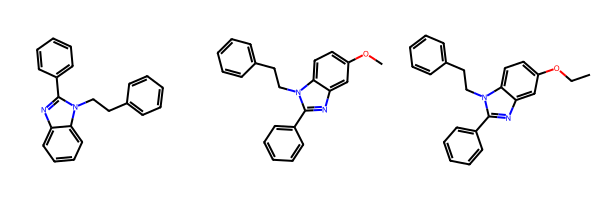

In [ ]:
entry_no = 6
original_smiles = safe_entries['original_smiles'].iloc[entry_no]
first_updated_smiles = safe_entries['updated_smiles_1'].iloc[entry_no]
second_updated_smiles = safe_entries['updated_smiles_2'].iloc[entry_no]
first_property = safe_entries['property_1'].iloc[entry_no]
second_property = safe_entries['property_2'].iloc[entry_no]
original_value = safe_entries['original_value'].iloc[entry_no]
first_updated_value = safe_entries['updated_value_1_x'].iloc[entry_no]
second_updated_value = safe_entries['updated_value_2'].iloc[entry_no]

matching_origin = update_origin_first[update_origin_first['SMILES'] == original_smiles]['Rationale'].values[0]
matching_update = update_first_second[update_first_second['SMILES'] == first_updated_smiles]['Rationale'].values[0]

matching_original_logPaap = original_property[original_property['SMILES'] == original_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update1_logPaap = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update2_logPaap = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]

matching_origin_logP = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update1_logP = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update2_logP = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]

matching_origin_logS = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update1_logS = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update2_logS = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log S] Predictions'].values[0]

print(f"{original_smiles}")
print(f"{first_updated_smiles}")
print(f"{second_updated_smiles}")
print(f"Update property: {first_property} --> {second_property}")
print(f"{original_value} -> {first_updated_value} -> {second_updated_value}")
print(f"Update Origin First Rationale: {matching_origin}")
print(f"Update First Second Rationale: {matching_update}")
print(f"LogPaap: {matching_original_logPaap} -> {matching_update1_logPaap} -> {matching_update2_logPaap}")
print(f"LogP: {matching_origin_logP} -> {matching_update1_logP} -> {matching_update2_logP}")
print(f"LogS: {matching_origin_logS} -> {matching_update1_logS} -> {matching_update2_logS}")





## Failure Case - Toxic-Toxic-Toxic


In [14]:

toxic_entries = merged[
    (merged['original_value'] == 'Toxic') & (merged['updated_value_1_x'] == 'Toxic') & (merged['updated_value_2'] == 'Toxic')
]
print(f"Number of toxic entries: {len(toxic_entries)}")
toxic_entries

Number of toxic entries: 8


,property_1,original_smiles,updated_smiles_1,original_value,updated_value_1_x,direction_1,property_2,updated_smiles_2,updated_value_1_y,updated_value_2,direction_2
51,[Toxicity/AMES Mutagenesis] Predictions,Cc1ncc([N+](=O)[O-])n1CC(O)C1OCC(O)C1O,Cc1ncc(C#N)n1CC(O)C1OCC(O)C1O,Toxic,Toxic,-,[Toxicity/AMES Mutagenesis] Predictions,Cc1ncc(C)n1CC(O)C1OCC(O)C1O,Toxic,Toxic,-
52,[Toxicity/Liver Injury I (DILI)] Predictions,Cc1ccc(C(=O)N=c2[nH]nc(-c3ccncc3)s2)s1,Cc1ccc(C(=O)N=c2[nH]nc(-c3ccncc3)s2)s1,Toxic,Toxic,-,[Toxicity/Liver Injury I (DILI)] Predictions,Cc1ccc(C(=O)N=C2N(C)nc(-c3ccncc3)s2)s1,Toxic,Toxic,-
54,[Toxicity/AMES Mutagenesis] Predictions,COc1ccc2c3c([nH]c2c(=O)c1O)CC(=O)CC3,COc1ccc2c3c([nH]c2c(=O)c1OC)CC(=O)CC3,Toxic,Toxic,-,[Toxicity/AMES Mutagenesis] Predictions,COc1ccc2c3c([nH]c2c(=O)c1OC)CC(=O)CC3,Toxic,Toxic,-
57,[Toxicity/AMES Mutagenesis] Predictions,Nc1cc(-c2cccs2)cc(-c2ccccc2)c1N,Nc1cc(-c2cccs2)cc(-c2ccncc2)c1N,Toxic,Toxic,-,[Toxicity/AMES Mutagenesis] Predictions,Nc1cc(-c2cccs2)cc(-c2ccncc2O)c1N,Toxic,Toxic,-
62,[Toxicity/Liver Injury I (DILI)] Predictions,Cc1ccc(C=CS(=O)(=O)Nc2ccccc2S(N)(=O)=O)cc1,Cc1ccc(C=CS(=O)(=O)Nc2ccccc2C(=O)N)cc1,Toxic,Toxic,-,[Toxicity/Liver Injury I (DILI)] Predictions,Cc1ccc(C=CS(=O)(=O)Nc2ccccc2C(=O)N)cc1,Toxic,Toxic,-
73,[Toxicity/AMES Mutagenesis] Predictions,O=C(C=Cc1ccc([N+](=O)[O-])cc1)NCCCCCN1CCCC[N+]1=O,O=C(C=Cc1ccc(N)cc1)NCCCCCN1CCCCN1,Toxic,Toxic,-,[Toxicity/AMES Mutagenesis] Predictions,O=C(C=Cc1ccc(N)cc1)NCCCCCN1CCCCN1,Toxic,Toxic,-
74,[Toxicity/Carcinogenesis] Predictions,CCCOC(=O)c1occc1NC(=O)OCc1ccccc1,CCCNC(=O)c1occc1NC(=O)OCc1ccccc1,Toxic,Toxic,-,[Toxicity/hERG Blockers] Predictions,CCCNC(=O)c1occc1NC(=O)OCc1ccncc1,Toxic,Toxic,-
79,[Toxicity/AMES Mutagenesis] Predictions,NC(=O)c1[nH]c(=Nc2cccc3ccccc23)sc1C(=O)c1ccccc1F,NC(=O)c1[nH]c(=Nc2cccc3ccccc23)sc1C(=O)c1ccccc1F,Toxic,Toxic,-,[Toxicity/AMES Mutagenesis] Predictions,NC(=O)c1[nH]c(=Nc2cccc3ccccc23)sc1C(=O)c1ccccc1F,Toxic,Toxic,-


Cc1ncc([N+](=O)[O-])n1CC(O)C1OCC(O)C1O
Cc1ncc(C#N)n1CC(O)C1OCC(O)C1O
Cc1ncc(C)n1CC(O)C1OCC(O)C1O
Update property: [Toxicity/AMES Mutagenesis] Predictions --> [Toxicity/AMES Mutagenesis] Predictions
Toxic -> Toxic -> Toxic
Update Origin First Rationale: The modification involves replacing the nitro group with a cyano group, which is generally less associated with mutagenicity. This change aims to reduce the mutagenic potential of the molecule while maintaining its activity against BCL-2.
Update First Second Rationale: The original molecule was predicted to be "Toxic" in AMES Mutagenesis, which is a significant concern for drug safety. By replacing the cyano group (C#N) with a methyl group, the mutagenicity risk may be reduced, potentially improving the safety profile of the compound.
LogPaap: -5.06 -> -5.19 -> -5.06
LogP: -1.31 -> -1.28 -> -0.97
LogS: -0.66 -> -0.61 -> -0.03


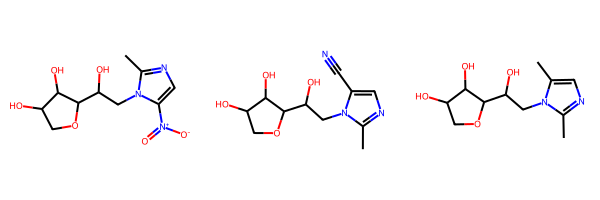

In [15]:
entry_no = 0
original_smiles = toxic_entries['original_smiles'].iloc[entry_no]
first_updated_smiles = toxic_entries['updated_smiles_1'].iloc[entry_no]
second_updated_smiles = toxic_entries['updated_smiles_2'].iloc[entry_no]
first_property = toxic_entries['property_1'].iloc[entry_no]
second_property = toxic_entries['property_2'].iloc[entry_no]
original_value = toxic_entries['original_value'].iloc[entry_no]
first_updated_value = toxic_entries['updated_value_1_x'].iloc[entry_no]
second_updated_value = toxic_entries['updated_value_2'].iloc[entry_no]

matching_origin = update_origin_first[update_origin_first['SMILES'] == original_smiles]['Rationale'].values[0]
matching_update = update_first_second[update_first_second['SMILES'] == first_updated_smiles]['Rationale'].values[0]

matching_original_logPaap = original_property[original_property['SMILES'] == original_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update1_logPaap = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]
matching_update2_logPaap = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[Absorption/Caco-2 (logPaap)] Predictions'].values[0]

matching_origin_logP = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update1_logP = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]
matching_update2_logP = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log(P)] Predictions'].values[0]

matching_origin_logS = original_property[original_property['SMILES'] == original_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update1_logS = first_updated_property[first_updated_property['SMILES'] == first_updated_smiles]['[General Properties/Log S] Predictions'].values[0]
matching_update2_logS = second_updated_property[second_updated_property['SMILES'] == second_updated_smiles]['[General Properties/Log S] Predictions'].values[0]

print(f"{original_smiles}")
print(f"{first_updated_smiles}")
print(f"{second_updated_smiles}")
print(f"Update property: {first_property} --> {second_property}")
print(f"{original_value} -> {first_updated_value} -> {second_updated_value}")
print(f"Update Origin First Rationale: {matching_origin}")
print(f"Update First Second Rationale: {matching_update}")
print(f"LogPaap: {matching_original_logPaap} -> {matching_update1_logPaap} -> {matching_update2_logPaap}")
print(f"LogP: {matching_origin_logP} -> {matching_update1_logP} -> {matching_update2_logP}")
print(f"LogS: {matching_origin_logS} -> {matching_update1_logS} -> {matching_update2_logS}")



smiles_list = [
    original_smiles,
    first_updated_smiles,
    second_updated_smiles
]
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200))

# Dimension Reduction

In [11]:
import json
import numpy as np
import pandas as pd
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import umap
from matplotlib.colors import ListedColormap

## File Preparation

In [ ]:
# import gzip

# sdf_path = '/home/hoon/dd-agent/chembl_35.sdf.gz'  # replace with your file name

# # Open and parse gzipped SDF in binary mode
# with gzip.open(sdf_path, 'rb') as f:
#     suppl = Chem.ForwardSDMolSupplier(f)
#     smiles_list = []

#     for mol in suppl:
#         if mol is not None:
#             smi = Chem.MolToSmiles(mol)
#             smiles_list.append(smi)

# # Output
# print(f"Extracted {len(smiles_list)} SMILES")
# print(smiles_list[:5])

[22:18:41] Both bonds on one end of an atropisomer are on the same side - atoms is : 6
[22:18:44] Explicit valence for atom # 0 P, 7, is greater than permitted
[22:18:44] ERROR: Could not sanitize molecule ending on line 2984972
[22:18:44] ERROR: Explicit valence for atom # 0 P, 7, is greater than permitted
[22:18:46] Explicit valence for atom # 1 P, 7, is greater than permitted
[22:18:46] ERROR: Could not sanitize molecule ending on line 3746750
[22:18:46] ERROR: Explicit valence for atom # 1 P, 7, is greater than permitted
[22:18:47] Explicit valence for atom # 1 P, 7, is greater than permitted
[22:18:47] ERROR: Could not sanitize molecule ending on line 3912154
[22:18:47] ERROR: Explicit valence for atom # 1 P, 7, is greater than permitted
[22:18:48] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 10 ignored.
[22:18:48] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 10 ignored.
[22:19:02] Warning: conflicting s

Extracted 2474577 SMILES
['Cc1cc(-c2csc(N=C(N)N)n2)cn1C', 'CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](N)CCSC)[C@@H](C)O)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1c[nH]cn1)C(=O)N[C@@H](CC(N)=O)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCN=C(N)N)C(=O)NCC(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)NCC(=O)N1CCC[C@H]1C(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](CCCN=C(N)N)C(N)=O', 'CCCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc2c[nH]cn2)NC(=O)[C@H](N)Cc2ccccc2)C(C)C)CCC(=O)NCCCC[C@@H](C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc2c[nH]cn2)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](

[22:27:38] Explicit valence for atom # 0 As, 7, is greater than permitted
[22:27:38] ERROR: Could not sanitize molecule ending on line 181113375
[22:27:38] ERROR: Explicit valence for atom # 0 As, 7, is greater than permitted
[22:27:38] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 29 ignored
[22:27:38] WARNING: not removing hydrogen atom without neighbors
[22:27:38] WARNING: not removing hydrogen atom without neighbors
[22:27:38] WARNING: not removing hydrogen atom without neighbors
[22:27:38] WARNING: not removing hydrogen atom without neighbors
[22:27:38] Explicit valence for atom # 22 P, 7, is greater than permitted
[22:27:38] ERROR: Could not sanitize molecule ending on line 181145109
[22:27:38] ERROR: Explicit valence for atom # 22 P, 7, is greater than permitted
[22:27:38] Explicit valence for atom # 0 P, 7, is greater than permitted
[22:27:38] ERROR: Could not sanitize molecule ending on line 181145299
[22:27:38] ERROR: Explicit valence for atom # 0 P, 7

In [ ]:
# len(smiles_list)

2474577

In [ ]:
# # randomly select 5000 SMILES by iterating through the list
# import random, pickle
# random.seed(42)  # For reproducibility
# # generate idx list between 0 and len(smiles_list) - 1
# selected_smiles_list = []
# idx_list = []
# for i in range(10000):
#     while True:
#         idx = random.randint(0, len(smiles_list) - 1)
#         if idx not in idx_list:  # ensure the index is unique
#             idx_list.append(idx)
#             break
    
#     # ensure the index is unique

 
#     smiles = smiles_list[idx]
#     selected_smiles_list.append(smiles)


# # save as pkl file
# with open('/home/hoon/dd-agent/sampled_smiles_42.pkl', 'wb') as f:
#     pickle.dump(selected_smiles_list, f)

## Plot 2D Map

In [12]:
def plot_molecular_latent_map(smiles_list, labels=None, use_umap=False):
    """
    Generate and visualize a 2D latent space of molecules using Mordred descriptors and t-SNE or UMAP.

    Args:
        smiles_list (list of str): List of SMILES strings.
        labels (list or Series, optional): Values used to color the points (e.g., property values or categories).
        use_umap (bool): Use UMAP instead of t-SNE for dimensionality reduction.
        title (str, optional): Plot title.
    """
    # Step 1: Parse SMILES
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
    valid_data = [(mol, smi, label)
                    for mol, smi, label in zip(mols, smiles_list, labels if labels is not None else [None] * len(smiles_list))
                    if mol is not None
                ]

    if not valid_data:
        print("No valid molecules found.")
        return

    valid_mols, valid_smiles, valid_labels = zip(*valid_data)

    # Step 2: Generate Descriptors
    calc = Calculator(descriptors, ignore_3D=True)
    desc_df = calc.pandas(valid_mols)
    desc_df = desc_df.loc[:, desc_df.applymap(lambda x: isinstance(x, (float, np.floating))).all()]
    desc_df = desc_df.dropna().reset_index(drop=True)

    # Step 3: Dimensionality Reduction
    if use_umap:
        X_reduced = umap.UMAP(n_components=2, random_state=42).fit_transform(desc_df)
    else:
        X_reduced = TSNE(n_components=2, random_state=42).fit_transform(desc_df)

    # Step 4: Plot
    plt.figure(figsize=(8, 8))
    if labels is not None:
        # Ensure labels match the filtered descriptor matrix
        label_series = pd.Series(valid_labels)
        label_codes, unique_labels = pd.factorize(label_series)

        # Generate colormap
        #cmap = cm.get_cmap('viridis', len(unique_labels))
        cmap = cm.get_cmap('tab20', len(unique_labels)) 
        base_cmap = cm.get_cmap('tab20')

        # Manually define colors for specific positions
        custom_colors = []

        # 1st: grey
        custom_colors.append('#d3d3d3')
        custom_colors.append('#1f77b4')  # blue
        custom_colors.append('#e67300')  # 3rd: orange
        custom_colors.append('#6baed6')  # 4th: lighter blue
        custom_colors.append('#ffb84d')
        custom_colors.append('crimson')  # or 'magenta', '#e60026', etc.

        # Fill up middle colors (6th to N-2)
        for i in range(5, len(unique_labels)-1):
            custom_colors.append(base_cmap(i))

        # Final custom colormap
        cmap = ListedColormap(custom_colors[:len(unique_labels)])
        norm = mcolors.BoundaryNorm(range(len(unique_labels) + 1), cmap.N)

        # Scatter plot with categorical coloring
        scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=label_codes, cmap=cmap, norm=norm, s=50)

        # Legend for categories
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', label=label,
                       markerfacecolor=cmap(norm(i)), markersize=8)
            for i, label in enumerate(unique_labels)
        ]
        plt.legend(
                    handles=handles,
                    fontsize=14,
                    frameon=True,
                    framealpha=0.6,
                    loc='lower left' # bottom left
                )
    else:
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c='blue', s=50)

    # for i, smi in enumerate(valid_smiles):
    #     if i < len(X_reduced):  # ensure valid index after dropna
    #         plt.text(X_reduced[i, 0], X_reduced[i, 1], smi, fontsize=8)

    # plt.xlabel("Axis 1")
    # plt.ylabel("Axis 2")
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.tight_layout()
    save_path = f"{save_directory}/{file_name}_{'umap' if use_umap else 'tsne'}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## Reinvent vs. Mol2Mol

In [13]:
# Load data
original_data = pd.read_csv(f"{save_directory}/{file_name}.csv")
updated_data = pd.read_csv(f"{save_directory}/{file_name}_update.csv")
updated_data['Method'] = "Updated " + updated_data['Method']

# Read drug smiles from JSON
with open("extraction.json", "r") as f:
    drug_data = json.load(f)

# Assuming drug_data['SMILES'] is a list
drug_smiles = [drug_data['SMILES']]

# Load random SMILES
random_smiles_list = pd.read_pickle("/home/hoon/dd-agent/sampled_smiles_42.pkl")
random_smiles_list = random_smiles_list[:1000]
# Combine SMILES
smiles_list = random_smiles_list + original_data['SMILES'].tolist() + updated_data['SMILES'].tolist()  + drug_smiles

# Combine Labels
labels_list = ["Random"] * len(random_smiles_list) + original_data['Method'].tolist() + updated_data['Method'].tolist() + ["Drug (Venetoclax)"] * len(drug_smiles)


In [14]:
#plot_molecular_latent_map(processed_data['smiles'], labels=processed_data['Method'])
plot_molecular_latent_map(smiles_list, labels=labels_list)

  1%|▏         | 15/1190 [00:02<02:04,  9.41it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  2%|▏         | 21/1190 [00:02<02:04,  9.41it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  4%|▍         | 47/1190 [00:03<01:08, 16.79it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  8%|▊         | 92/1190 [00:04<00:35, 31.32it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  8%|▊         | 97/1190 [00:04<00:49, 21.95it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 10%|▉         | 115/1190 [00:05<00:34, 30.88it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 18%|█▊        | 214/1190 [00:12<00:57, 16.96it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 27%|██▋       | 323/1190 [00:16<00:35, 24.09it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 61%|██████▏   | 730/1190 [00:30<00:44, 10.27it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1190/1190 [00:45<00:00, 26.31it/s]
/tmp/ipykernel_1770069/3478812013.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_df = desc_df.loc[:, desc_df.applymap(lambda x: isinstance(x, (float, np.floating))).all()]
/tmp/ipykernel_1770069/3478812013.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))
/tmp/ipykernel_1770069/3478812013.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('tab20')


In [15]:
plot_molecular_latent_map(smiles_list, labels=labels_list, use_umap=True)

  1%|          | 7/1190 [00:01<04:34,  4.32it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  2%|▏         | 21/1190 [00:02<02:11,  8.88it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  7%|▋         | 80/1190 [00:03<00:25, 44.14it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 10%|█         | 122/1190 [00:04<00:29, 36.80it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 15%|█▍        | 175/1190 [00:09<02:28,  6.83it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 17%|█▋        | 198/1190 [00:11<01:11, 13.87it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 27%|██▋       | 323/1190 [00:16<00:33, 25.73it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|███▏      | 383/1190 [00:17<00:21, 37.22it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 60%|█████▉    | 710/1190 [00:29<00:38, 12.55it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 67%|██████▋   | 797/1190 [00:34<00:28, 14.01it/s]

/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1190/1190 [00:44<00:00, 26.49it/s]
/tmp/ipykernel_1770069/3478812013.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_df = desc_df.loc[:, desc_df.applymap(lambda x: isinstance(x, (float, np.floating))).all()]
/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hoon/anaconda3/envs/reinvent4/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_1770069/3478812013.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))
/tm

## Original vs. Updated

# Playground

In [33]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED

TARGET_PROPERTY = 'absorption'

# Define key ADMET properties
property_map = {
    'absorption': '[Absorption/Human Oral Bioavailability 50%] Predictions',
    'distribution': '[Distribution/Blood-Brain Barrier] Predictions',
    'metabolism': '[Metabolism/CYP 1A2 Inhibitor] Predictions',
    'excretion': '[Excretion/Half-Life of Drug] Predictions',
    'toxicity': '[Toxicity/Liver Injury I (DILI)] Predictions',
    'binding_affinity':  'Affinity [pKa]', 
    # 'qed_score': 'QED',
}
drug_likness_rules = ["lipinski_rule_of_5",	
                      "veber_rule",	
                      "ghose_filter",	
                      "rule_of_3",
                      "pfizer_rule_of_4",	
                      "oprea_lead_like"]


key_properties = {TARGET_PROPERTY: property_map[TARGET_PROPERTY]}
# Load property and assessment files
property_file_path = "property/combined.csv"
assess_file_path = f"assessment/{TARGET_PROPERTY}.csv"

df_prop = pd.read_csv(property_file_path)
df_assess = pd.read_csv(assess_file_path)
# only keep key properties in df_prop
df_prop = df_prop[['SMILES'] + list(key_properties.values())]
# df_prop = df_prop[['SMILES'] + [key_properties]]
# number of passed rules in df_assess
num_passed_rules = df_assess[drug_likness_rules].sum(axis=1)
df_assess['num_passed_rules'] = num_passed_rules
# drop the drug likeness rules columns from df_assess
df_assess = df_assess[['SMILES', 'LLM_Assessment', 'num_passed_rules']]

# Merge based on SMILES to ensure alignment 

df_merged = pd.merge(df_prop, df_assess, on='SMILES', how='inner')

# Add QED column 
df_merged['QED'] = df_merged['SMILES'].apply(lambda x: QED.qed(Chem.MolFromSmiles(x)))

# Split into YES and NO groups
# only input yes or no in the llm_assessment column. the assessment starts with yes or no
df_yes = df_merged[df_merged['LLM_Assessment'].str.startswith('YES')]
df_yes.loc[:, 'LLM_Assessment'] = "YES"
df_no = df_merged[df_merged['LLM_Assessment'].str.startswith('NO')]
df_no.loc[:, 'LLM_Assessment'] = "NO"

# restack df_yes and df_no 
df = pd.concat([df_yes, df_no], ignore_index=True)

key_properties['qed_score'] = 'QED'  # Add QED to key properties
key_properties['rule_evaluation'] = 'num_passed_rules'  # Add rule evaluation to key properties
# key_properties['binding_affinity'] = 'Affinity [pKa]'  # Add binding affinity to key properties
# Function to extract key properties
def extract_key_properties(df, group_label):
    print(f"\n--- {group_label.upper()} GROUP ---")
    for key, column in key_properties.items():
        if column in df.columns:
            values = df[column].tolist()
            print(f"{key}: {values}")
        else:
            print(f"{key}: Column '{column}' not found.")

# Extract and print
extract_key_properties(df_yes, "yes")
extract_key_properties(df_no, "no")


--- YES GROUP ---
absorption: ['Bioavailable']
qed_score: [0.6711318184155992]
rule_evaluation: [3]

--- NO GROUP ---
absorption: ['Bioavailable', 'Bioavailable', 'Bioavailable', 'Bioavailable', 'Bioavailable', 'Bioavailable', 'Bioavailable', 'Bioavailable', 'Bioavailable', 'Non-Bioavailable', 'Bioavailable', 'Bioavailable']
qed_score: [0.4197100429551858, 0.4476769562041517, 0.7501563688357807, 0.8538344135634358, 0.6579436405351512, 0.8319923529597417, 0.759435946369013, 0.8587303707389224, 0.7851816474976089, 0.5318339579583671, 0.8527178546926073, 0.5663611049052861]
rule_evaluation: [3, 4, 5, 5, 4, 5, 5, 5, 5, 5, 4, 3]


In [34]:
df_yes.describe() 

,num_passed_rules,QED
count,1.0,1.000000
mean,3.0,0.671132
std,NaN,NaN
min,3.0,0.671132
25%,3.0,0.671132
50%,3.0,0.671132
75%,3.0,0.671132
max,3.0,0.671132


In [35]:
df_no.describe()

,num_passed_rules,QED
count,12.000000,12.000000
mean,4.416667,0.692965
std,0.792961,0.163054
min,3.000000,0.419710
25%,4.000000,0.557729
50%,5.000000,0.754796
75%,5.000000,0.837174
max,5.000000,0.858730


In [31]:
df_assess 

,SMILES,LLM_Assessment,num_passed_rules
0,O=C(NS(=O)(=O)c1ccc(N2CCOCC2=O)c(Cl)c1)c1ccc(N...,"YES, the molecule can be considered a potentia...",3
1,O=C(NS(=O)(=O)c1ccc(Cl)s1)c1ccc(N2CCN(CC3CC3)C...,"YES, the molecule can be considered a potentia...",3
2,CC(N=c1[nH]cnc2[nH]cnc12)c1cc2cccc(F)c2c(=O)n1...,NO. While the molecule shows potential for abs...,4
3,CCOc1ccc(NS(=O)(=O)c2c(C(=O)N3CCCCCC3)c(C)n(C)...,"NO. The molecule has poor Caco-2 permeability,...",5
4,CCCSc1n[nH]c(=NC(=O)C23CC4CC(CC(C4)C2)C3)s1,"YES, the molecule can be considered a potentia...",5
5,CCSc1scc(C)c1C#N,NO. The molecule has favorable human oral bioa...,4
6,COC(=O)c1c(NC(=O)C2CCC2C)sc(C)c1-c1ccccc1,NO. The molecule has critical issues such as p...,5
7,O=C(O)c1ccccc1N=c1cnc(Sc2ccc(F)cc2)c[nH]1,NO. The molecule has critical issues such as l...,5
8,CN(C)C(=O)c1cccc(C(NCCN)c2ccc(F)cc2)c1,NO. The molecule shows some positive absorptio...,5
9,COc1cc2c(cc1OC)C(C)N(C(=O)c1ccc(=O)n(CC(F)F)c1...,NO. The molecule has poor Caco-2 permeability ...,5


Number of SMILES: 46


[19:37:20] SMILES Parse Error: syntax error while parsing: CC(C)C(=O)Si
[19:37:20] SMILES Parse Error: check for mistakes around position 12:
[19:37:20] CC(C)C(=O)Si
[19:37:20] ~~~~~~~~~~~^
[19:37:20] SMILES Parse Error: Failed parsing SMILES 'CC(C)C(=O)Si' for input: 'CC(C)C(=O)Si'
[19:37:20] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:37:20] Explicit valence for atom # 5 N, 5, is greater than permitted
100%|██████████| 43/43 [00:00<00:00, 204.99it/s]
/tmp/ipykernel_1235812/2211834366.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_df = desc_df.loc[:, desc_df.applymap(lambda x: isinstance(x, (float, np.floating))).all()]


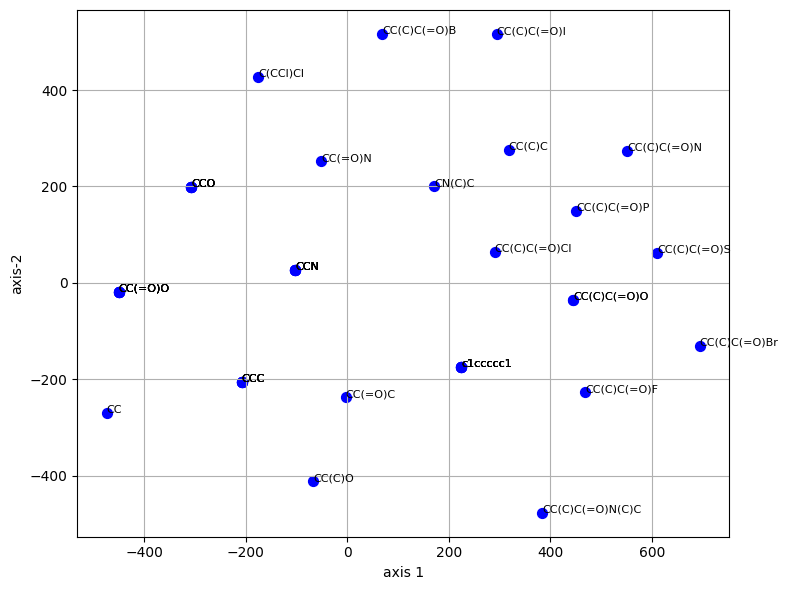

In [24]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from mordred import Calculator, descriptors
from sklearn.manifold import TSNE
import umap
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Step 1: Input SMILES
# ----------------------
smiles_list = [
    "CCO", "CCN", "CCC", "c1ccccc1", "CC(=O)O", 
    "C(CCl)Cl", "CC(C)O", "CC(C)C(=O)O", "CC", "CN(C)C",
    "CC(=O)N", "CC(=O)C", "CC(C)C", "CC(C)C(=O)N",
    "CC(C)C(=O)O", "CC(C)C(=O)Cl", "CC(C)C(=O)Br",
    "CC(C)C(=O)I", "CC(C)C(=O)F", "CC(C)C(=O)S",
    "CC(C)C(=O)P", "CC(C)C(=O)Si", "CC(C)C(=O)B",
    "CC(C)C(=O)N(C)C", "CC(C)C(=O)N(C)(C)C", "CC(C)C(=O)N(C)(C)(C)C",
    "CCO", "CCN", "CCC", "c1ccccc1", "CC(=O)O", 
    "CCO", "CCN", "CCC", "c1ccccc1", "CC(=O)O", 
    "CCO", "CCN", "CCC", "c1ccccc1", "CC(=O)O", 
    "CCO", "CCN", "CCC", "c1ccccc1", "CC(=O)O", 
]
print(f"Number of SMILES: {len(smiles_list)}")
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]

# Remove invalid molecules
valid_mols = [mol for mol in mols if mol is not None]
valid_smiles = [smi for mol, smi in zip(mols, smiles_list) if mol is not None]

# ----------------------
# Step 2: Generate Descriptors
# ----------------------
calc = Calculator(descriptors, ignore_3D=True)
desc_df = calc.pandas(valid_mols)
# desc_df = desc_df.dropna(axis=1)  # drop columns with NaNs
desc_df = desc_df.loc[:, desc_df.applymap(lambda x: isinstance(x, (float, np.floating))).all()]
# Drop rows with any remaining NaNs
#desc_df = desc_df.dropna(axis=0).reset_index(drop=True)

# ----------------------
# Step 3: Dimensionality Reduction
# ----------------------

# # Use UMAP
# X_reduced = umap.UMAP(n_components=2, random_state=42).fit_transform(desc_df)

# Alternative: t-SNE (uncomment to use)
# from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2, random_state=42).fit_transform(desc_df)

# ----------------------
# Step 4: Visualization
# ----------------------
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c='blue', s=50)

for i, smi in enumerate(valid_smiles):
    plt.text(X_reduced[i, 0], X_reduced[i, 1], smi, fontsize=8)

# plt.title("Molecular Latent Map (t-SNE from Mordred Descriptors)")
plt.xlabel("axis 1")
plt.ylabel("axis-2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
desc_df #.head()

,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,...,SRW08,SRW09,SRW10,TSRW10,MW,AMW,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,1.707107,0.569036,-0.669173,3.363586,...,3.496508,0.0,4.174387,17.310771,46.041865,5.115763,6.0,4.0,2.250000,1.000000
1,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,1.707107,0.569036,-0.669173,3.363586,...,3.496508,0.0,4.174387,17.310771,45.057849,4.505785,6.0,4.0,2.250000,1.000000
2,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,1.707107,0.569036,-0.669173,3.363586,...,3.496508,0.0,4.174387,17.310771,44.062600,4.005691,6.0,4.0,2.250000,1.000000
3,8.000000,2.000000,4.000000,8.000000,1.333333,2.687624,2.449490,0.408248,0.385054,14.696938,...,6.248043,0.0,7.627057,30.941317,78.046950,6.503913,24.0,24.0,1.500000,1.500000
4,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,1.931852,0.482963,-0.257812,5.583629,...,5.093750,0.0,6.188264,24.179697,60.021129,7.502641,12.0,9.0,3.111111,1.000000
5,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,1.946498,0.486624,-0.250259,5.891993,...,4.553877,0.0,5.509388,22.328143,97.969005,12.246126,10.0,8.0,2.500000,1.250000
6,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,1.931852,0.482963,-0.257812,5.583629,...,5.093750,0.0,6.188264,24.179697,60.057515,5.004793,12.0,9.0,3.111111,1.000000
7,6.000000,2.000000,4.000000,6.000000,1.000000,2.610845,2.309401,0.384900,0.326163,11.530010,...,6.244167,0.0,7.626083,30.698690,88.052429,6.289459,22.0,21.0,4.222222,1.444444
8,2.000000,1.000000,2.000000,2.000000,1.000000,1.407606,1.414214,0.707107,-1.262864,1.414214,...,1.098612,0.0,1.098612,7.493061,30.046950,3.755869,2.0,1.0,2.000000,1.000000
9,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,1.931852,0.482963,-0.257812,5.583629,...,5.093750,0.0,6.188264,24.179697,59.073499,4.544115,12.0,9.0,3.111111,1.000000


In [21]:
desc_df['MAXssNH'].iloc[0]

In [8]:
desc_df.isna().sum().sort_values(ascending=False).head(10)


ABC         0
MAXssNH     0
MAXsOH      0
MAXssssN    0
MAXaasN     0
MAXddsN     0
MAXsssN     0
MAXaaN      0
MAXdsN      0
MAXsssNH    0
dtype: int64

In [ ]:
from rdkit import Chem
from mol2vec.features import mol2alt_sentence
from rdkit.Chem import AllChem
import numpy as np

# read /home/hoon/dd-agent/llm_dd/examples/BCL-2/pool/dummy.csv
smiles_path = "/home/hoon/dd-agent/llm_dd/examples/BCL-2/pool/dummy.csv"
df_smiles = pd.read_csv(smiles_path)


# Example SMILES
smiles_list = df_smiles['SMILES'].tolist() # ["CCO", "CCN", "CCC"]
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]

# Convert to "sentences"
sentences = [mol2alt_sentence(mol, radius=1) for mol in mols]
sentences = [mol2alt_sentence(m, 1) for m in mols]
# X = np.array([model.infer_vector(s) for s in sentences])

[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerator
[14:43:35] DEPRECATION WARNING: please use MorganGenerat

In [39]:
from rdkit.Chem import AllChem
import numpy as np

fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in mols]
X = np.array([list(fp) for fp in fps])

[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerator
[14:44:45] DEPRECATION WARNING: please use MorganGenerat

In [33]:
for x in X[0]:
    print(x)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0


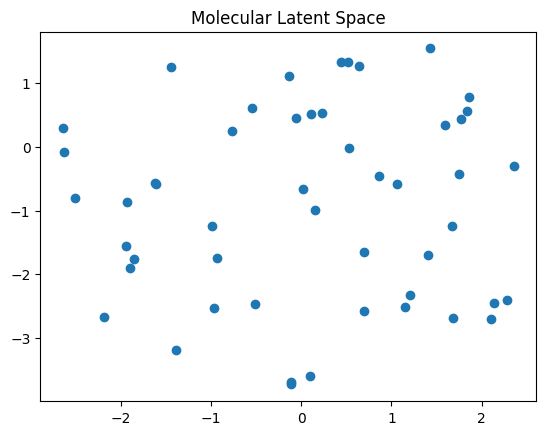

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_2d = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.title("Molecular Latent Space")
plt.show()

In [12]:
!pip install umap-learn

In [15]:
import umap
X_2d = umap.UMAP(n_components=2).fit_transform(X)

AttributeError: module 'umap' has no attribute 'UMAP'

In [1]:
import os, sys
cwd = os.getcwd()
print("Current working directory:", cwd)
home_dir = os.path.dirname(os.path.dirname(cwd))
print("Home directory:", home_dir)
sys.path.append(home_dir)

Current working directory: /home/hoon/dd-agent/llm_dd/examples/BCL-2
Home directory: /home/hoon/dd-agent/llm_dd


In [2]:
import pandas as pd
from agentD.analysis_utils import rule_based_evaluation

In [7]:
data_path = "/home/hoon/dd-agent/llm_dd/examples/BCL-2/property/combined_dummy.csv"

# "/home/hoon/dd-agent/llm_dd/examples/BCL-2/assessment/objective_dummy2.csv"
#"/home/hoon/dd-agent/llm_dd/examples/BCL-2/property/combined_dummy.csv"
#"/home/hoon/dd-agent/llm_dd/examples/BCL-2/downselection/objective_dummy.csv"
df = pd.read_csv(data_path)
df 

,SMILES,[Absorption/Caco-2 (logPaap)] Predictions,[Absorption/Caco-2 (logPaap)] Interpretation,[Absorption/Human Oral Bioavailability 20%] Predictions,[Absorption/Human Oral Bioavailability 20%] Probability,[Absorption/Human Oral Bioavailability 20%] Interpretation,[Absorption/Human Intestinal Absorption] Predictions,[Absorption/Human Intestinal Absorption] Probability,[Absorption/Human Intestinal Absorption] Interpretation,[Absorption/Madin-Darby Canine Kidney] Predictions,...,[General Properties/Log S] Interpretation,[General Properties/Log(Vapor Pressure)] Predictions,[General Properties/Log(Vapor Pressure)] Interpretation,[General Properties/Melting Point] Predictions,[General Properties/Melting Point] Interpretation,[General Properties/pKa Acid] Predictions,[General Properties/pKa Acid] Interpretation,[General Properties/pKa Basic] Predictions,[General Properties/pKa Basic] Interpretation,Affinity [pKa]
0,O=C(NS(=O)(=O)c1ccc(N2CCN(CCO)CC2)cc1)c1ccc(N2...,-5.66,NaN,Bioavailable,0.686,Bioavailable (Medium Confidence),Absorbed,0.971,Absorbed (High Confidence),-5.29,...,Proper Value: -4 to 0.5 log mol/L,-10.98,Vapor (Gas) Phase: log vp < 4; Vapor and Parti...,180.22,MP<25: liquid; MP>25:solid,2.88,NaN,5.04,NaN,5.731408
1,O=C(NS(=O)(=O)c1ccc(N2CCOCC2)c([N+](=O)[O-])c1...,-5.56,NaN,Bioavailable,0.839,Bioavailable (High Confidence),Absorbed,0.981,Absorbed (High Confidence),-4.98,...,Proper Value: -4 to 0.5 log mol/L,-10.59,Vapor (Gas) Phase: log vp < 4; Vapor and Parti...,220.45,MP<25: liquid; MP>25:solid,2.80,NaN,6.30,NaN,6.181618


In [8]:
list(df.columns)

['SMILES',
 '[Absorption/Caco-2 (logPaap)] Predictions',
 '[Absorption/Caco-2 (logPaap)] Interpretation',
 '[Absorption/Human Oral Bioavailability 20%] Predictions',
 '[Absorption/Human Oral Bioavailability 20%] Probability',
 '[Absorption/Human Oral Bioavailability 20%] Interpretation',
 '[Absorption/Human Intestinal Absorption] Predictions',
 '[Absorption/Human Intestinal Absorption] Probability',
 '[Absorption/Human Intestinal Absorption] Interpretation',
 '[Absorption/Madin-Darby Canine Kidney] Predictions',
 '[Absorption/Madin-Darby Canine Kidney] Interpretation',
 '[Absorption/Human Oral Bioavailability 50%] Predictions',
 '[Absorption/Human Oral Bioavailability 50%] Probability',
 '[Absorption/Human Oral Bioavailability 50%] Interpretation',
 '[Absorption/P-Glycoprotein Inhibitor] Predictions',
 '[Absorption/P-Glycoprotein Inhibitor] Probability',
 '[Absorption/P-Glycoprotein Inhibitor] Interpretation',
 '[Absorption/P-Glycoprotein Substrate] Predictions',
 '[Absorption/P-Glycop

In [4]:
entry = df.iloc[0].to_dict()
report = rule_based_evaluation(entry)

In [5]:
report

{'smiles': 'O=C(NS(=O)(=O)c1ccc(N2CCN(CCO)CC2)cc1)c1ccc(N2CCOCC2)c([N+](=O)[O-])c1',
 'lipinski_rule_of_5': True,
 'veber_rule': False,
 'ghose_filter': False,
 'rule_of_3': False,
 'pfizer_rule_of_4': False,
 'oprea_lead_like': False,
 'fda_criteria': False,
 'fda_approval_category': 'Low'}